In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Cargar datos limpios
tpm = pd.read_csv("../data/processed/transporte_publico_madrid_limpio.csv", parse_dates=['fecha'])
accidentes = pd.read_csv("../data/processed/accidentes_madrid_limpio.csv", parse_dates=['fecha', 'fecha_hora'])

ModuleNotFoundError: No module named 'statsmodels'

Análisis de Correlación

In [ ]:
def analisis_correlacion(tpm_data, accidentes_data):
    print("=" * 60)
    print("ANÁLISIS DE CORRELACIÓN")
    print("=" * 60)
    
    # Preparar datos para análisis de correlación
    tpm_mensual = tpm_data[tpm_data['tipo_indicador'] == 'Viajeros']
    tpm_mensual = tpm_mensual.groupby(pd.Grouper(key='fecha', freq='M'))['valor'].sum().reset_index()
    tpm_mensual.rename(columns={'valor': 'viajeros'}, inplace=True)
    
    accidentes_mensual = accidentes_data.groupby(pd.Grouper(key='fecha', freq='M')).size().reset_index()
    accidentes_mensual.rename(columns={0: 'accidentes'}, inplace=True)
    
    # Unir datos
    datos_correlacion = pd.merge(tpm_mensual, accidentes_mensual, on='fecha', how='inner')
    
    # Calcular correlación de Pearson
    correlacion, p_valor = pearsonr(datos_correlacion['viajeros'], datos_correlacion['accidentes'])
    
    print(f"Correlación entre viajeros y accidentes: {correlacion:.3f}")
    print(f"Valor p: {p_valor:.4f}")
    
    if p_valor < 0.05:
        print("La correlación es estadísticamente significativa (p < 0.05)")
    else:
        print("La correlación NO es estadísticamente significativa")
    
    # Matriz de correlación para variables numéricas
    variables_numericas = accidentes_data.select_dtypes(include=[np.number]).columns
    matriz_correlacion = accidentes_data[variables_numericas].corr()
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(12, 8))
    sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Matriz de Correlación - Variables Numéricas de Accidentes', fontsize=16)
    plt.tight_layout()
    plt.savefig('../visualizations/matriz_correlacion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlacion, p_valor, matriz_correlacion

# Ejecutar análisis de correlación
correlacion, p_valor, matriz_correlacion = analisis_correlacion(tpm, accidentes)

Tests de Hipótesis

C:\Users\ambio\AppData\Local\Temp\ipykernel_13680\326437702.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_final , x='Año', y='Precio_Indice', hue='Sector', ci=None)
C:\Users\ambio\AppData\Local\Temp\ipykernel_13680\326437702.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


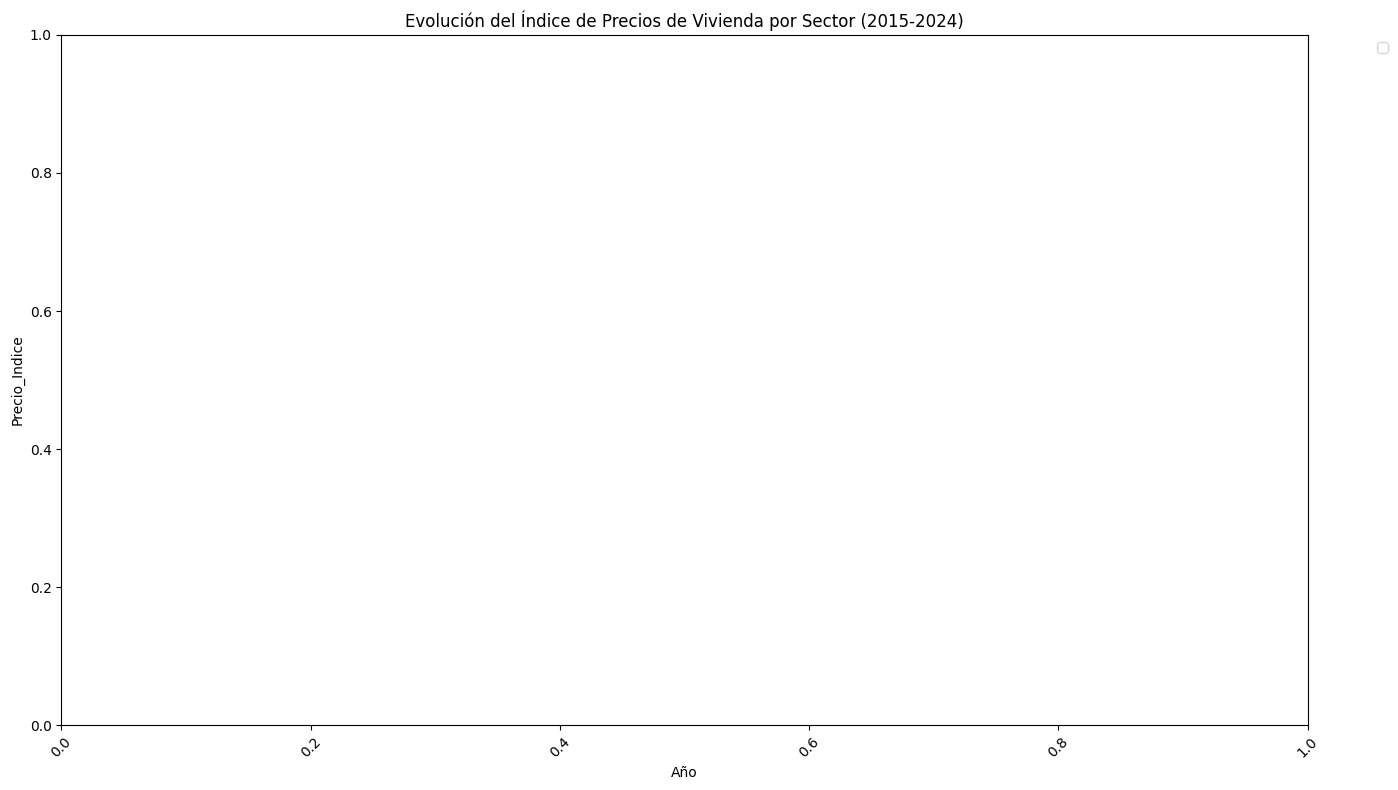

In [ ]:
def tests_hipotesis(accidentes_data):
    print("=" * 60)
    print("TESTS DE HIPÓTESIS")
    print("=" * 60)
    
    resultados_hipotesis = {}
    
    # 1. ¿Existen diferencias significativas en accidentes entre días laborables y fines de semana?
    accidentes_data['es_fin_semana'] = accidentes_data['dia_semana'].isin(['Saturday', 'Sunday'])
    laborables = accidentes_data[~accidentes_data['es_fin_semana']]['hora_dia']
    fin_semana = accidentes_data[accidentes_data['es_fin_semana']]['hora_dia']
    
    t_stat, p_valor = ttest_ind(laborables, fin_semana, nan_policy='omit')
    resultados_hipotesis['laborables_vs_fin_semana'] = {'t_stat': t_stat, 'p_valor': p_valor}
    
    print("1. Diferencia en hora de accidentes (laborables vs fin de semana):")
    print(f"   t-statistic: {t_stat:.3f}, p-value: {p_valor:.4f}")
    
    # 2. ¿Existen diferencias en la gravedad entre tipos de vehículo?
    # Preparar datos para ANOVA
    vehiculos_comunes = accidentes_data['tipo_vehiculo'].value_counts().head(5).index
    datos_vehiculos = [accidentes_data[accidentes_data['tipo_vehiculo'] == v]['cod_lesividad'] 
                      for v in vehiculos_comunes if len(accidentes_data[accidentes_data['tipo_vehiculo'] == v]) > 30]
    
    if len(datos_vehiculos) >= 2:
        f_stat, p_valor = f_oneway(*datos_vehiculos)
        resultados_hipotesis['gravedad_por_vehiculo'] = {'f_stat': f_stat, 'p_valor': p_valor}
        
        print("\n2. Diferencias en gravedad por tipo de vehículo (ANOVA):")
        print(f"   F-statistic: {f_stat:.3f}, p-value: {p_valor:.4f}")
    
    # 3. ¿Existe asociación entre sexo y gravedad del accidente?
    tabla_contingencia = pd.crosstab(accidentes_data['sexo'], accidentes_data['gravedad'])
    chi2, p_valor, dof, expected = chi2_contingency(tabla_contingencia)
    resultados_hipotesis['sexo_vs_gravedad'] = {'chi2': chi2, 'p_valor': p_valor, 'dof': dof}
    
    print("\n3. Asociación entre sexo y gravedad (Chi-cuadrado):")
    print(f"   Chi-square: {chi2:.3f}, p-value: {p_valor:.4f}, df: {dof}")
    
    # 4. ¿Los accidentes con alcohol son más graves?
    con_alcohol = accidentes_data[accidentes_data['positiva_alcohol'] == 1]['cod_lesividad']
    sin_alcohol = accidentes_data[accidentes_data['positiva_alcohol'] == 0]['cod_lesividad']
    
    t_stat, p_valor = ttest_ind(con_alcohol, sin_alcohol, nan_policy='omit', equal_var=False)
    resultados_hipotesis['alcohol_vs_gravedad'] = {'t_stat': t_stat, 'p_valor': p_valor}
    
    print("\n4. Diferencia en gravedad (accidentes con vs sin alcohol):")
    print(f"   t-statistic: {t_stat:.3f}, p-value: {p_valor:.4f}")
    
    return resultados_hipotesis

# Ejecutar tests de hipótesis
resultados_hipotesis = tests_hipotesis(accidentes)

Modelos de Regresión

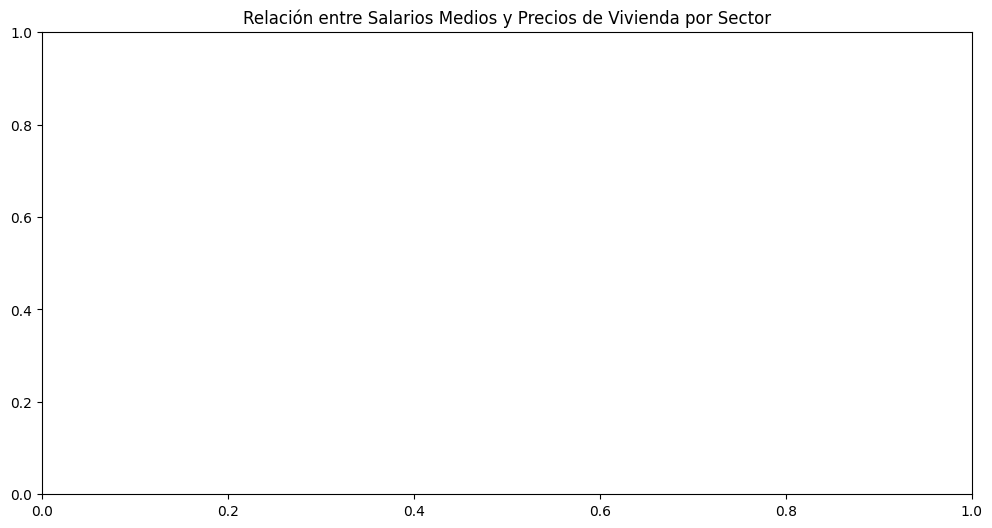

In [ ]:
def modelos_regresion(accidentes_data):
    print("=" * 60)
    print("MODELOS DE REGRESIÓN")
    print("=" * 60)
    
    # Preparar datos para regresión
    datos_regresion = accidentes_data.copy()
    
    # Codificar variables categóricas
    variables_categoricas = ['distrito', 'tipo_accidente', 'estado_meteorologico', 
                            'tipo_vehiculo', 'franja_horaria']
    
    for var in variables_categoricas:
        datos_regresion[var] = datos_regresion[var].astype('category').cat.codes
    
    # 1. Regresión lineal múltiple para predecir gravedad
    X = datos_regresion[['distrito', 'tipo_accidente', 'estado_meteorologico', 
                        'tipo_vehiculo', 'hora_dia', 'franja_horaria']]
    X = sm.add_constant(X)  # añadir intercepto
    y = datos_regresion['cod_lesividad']
    
    # Eliminar filas con valores missing
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    modelo = sm.OLS(y, X).fit()
    
    print("1. MODELO DE REGRESIÓN LINEAL MÚLTIPLE")
    print("Variable dependiente: Gravedad del accidente (cod_lesividad)")
    print(modelo.summary())
    
    # 2. Regresión logística para predecir accidentes con alcohol
    from statsmodels.discrete.discrete_model import Logit
    
    X_logit = datos_regresion[['distrito', 'tipo_accidente', 'hora_dia', 'franja_horaria']]
    X_logit = sm.add_constant(X_logit)
    y_logit = datos_regresion['positiva_alcohol']
    
    # Eliminar filas con valores missing
    mask_logit = ~(X_logit.isnull().any(axis=1) | y_logit.isnull())
    X_logit = X_logit[mask_logit]
    y_logit = y_logit[mask_logit]
    
    modelo_logit = Logit(y_logit, X_logit).fit(disp=0)
    
    print("\n2. MODELO DE REGRESIÓN LOGÍSTICA")
    print("Variable dependiente: Positivo en alcohol (0/1)")
    print(modelo_logit.summary())
    
    # 3. Evaluar importancia de variables
    coeficientes = pd.DataFrame({
        'variable': X.columns,
        'coeficiente': modelo.params,
        'p_valor': modelo.pvalues
    }).sort_values('coeficiente', key=abs, ascending=False)
    
    print("\n3. IMPORTANCIA DE VARIABLES (por valor absoluto del coeficiente)")
    print(coeficientes.head(10))
    
    return modelo, modelo_logit, coeficientes

# Ejecutar modelos de regresión
modelo_lineal, modelo_logit, coeficientes = modelos_regresion(accidentes)

Análisis de Series Temporales

In [ ]:
def analisis_series_temporales(tpm_data, accidentes_data):
    print("=" * 60)
    print("ANÁLISIS DE SERIES TEMPORALES")
    print("=" * 60)
    
    # Preparar series temporales mensuales
    tpm_mensual = tpm_data[tpm_data['tipo_indicador'] == 'Viajeros']
    tpm_mensual = tpm_mensual.groupby(pd.Grouper(key='fecha', freq='M'))['valor'].sum()
    
    accidentes_mensual = accidentes_data.groupby(pd.Grouper(key='fecha', freq='M')).size()
    
    # 1. Descomposición de series temporales - Accidentes
    descomposicion_accidentes = seasonal_decompose(accidentes_mensual, model='additive', period=12)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    descomposicion_accidentes.observed.plot(ax=axes[0], title='Observado (Accidentes)')
    descomposicion_accidentes.trend.plot(ax=axes[1], title='Tendencia')
    descomposicion_accidentes.seasonal.plot(ax=axes[2], title='Estacionalidad')
    descomposicion_accidentes.resid.plot(ax=axes[3], title='Residuales')
    
    plt.tight_layout()
    plt.savefig('../visualizations/descomposicion_series_temporales.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Test de estacionariedad (Dickey-Fuller aumentado)
    from statsmodels.tsa.stattools import adfuller
    
    print("TEST DE ESTACIONARIEDAD - ACCIDENTES MENSUALES")
    resultado_adf = adfuller(accidentes_mensual.dropna())
    print(f'Estadístico ADF: {resultado_adf[0]:.3f}')
    print(f'p-value: {resultado_adf[1]:.3f}')
    print('Valores críticos:')
    for key, value in resultado_adf[4].items():
        print(f'   {key}: {value:.3f}')
    
    if resultado_adf[1] < 0.05:
        print("La serie es ESTACIONARIA (rechazamos H0)")
    else:
        print("La serie NO es estacionaria (no podemos rechazar H0)")
    
    # 3. Autocorrelación y autocorrelación parcial
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(accidentes_mensual.dropna(), lags=24, ax=axes[0])
    axes[0].set_title('Autocorrelación (ACF) - Accidentes Mensuales')
    
    plot_pacf(accidentes_mensual.dropna(), lags=24, ax=axes[1])
    axes[1].set_title('Autocorrelación Parcial (PACF) - Accidentes Mensuales')
    
    plt.tight_layout()
    plt.savefig('../visualizations/autocorrelacion_accidentes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return descomposicion_accidentes, resultado_adf

# Ejecutar análisis de series temporales
descomposicion, resultado_adf = analisis_series_temporales(tpm, accidentes)


Análisis de Cluster y PCA

In [ ]:
def analisis_cluster_pca(accidentes_data):
    print("=" * 60)
    print("ANÁLISIS DE CLUSTER Y PCA")
    print("=" * 60)
    
    # Preparar datos para clustering
    datos_cluster = accidentes_data.groupby('distrito').agg({
        'cod_lesividad': 'mean',  # Gravedad promedio
        'hora_dia': 'mean',       # Hora promedio de accidentes
        'positiva_alcohol': 'mean', # Porcentaje de positivos en alcohol
        'num_expediente': 'count'   # Número total de accidentes
    }).rename(columns={'num_expediente': 'total_accidentes'})
    
    # Estandarizar datos
    scaler = StandardScaler()
    datos_escalados = scaler.fit_transform(datos_cluster)
    datos_escalados = pd.DataFrame(datos_escalados, 
                                  columns=datos_cluster.columns, 
                                  index=datos_cluster.index)
    
    # 1. Determinar número óptimo de clusters (método del codo)
    inercia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(datos_escalados)
        inercia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), inercia, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para Determinar K Óptimo')
    plt.savefig('../visualizations/metodo_codo_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Aplicar K-means con k óptimo (elegir 3 basado en el gráfico)
    k_optimo = 3
    kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(datos_escalados)
    
    datos_cluster['cluster'] = clusters
    
    print(f"Distribución de distritos en {k_optimo} clusters:")
    print(datos_cluster['cluster'].value_counts())
    
    # 3. Análisis de Componentes Principales (PCA)
    pca = PCA(n_components=2)
    componentes_principales = pca.fit_transform(datos_escalados)
    
    # Visualizar clusters en espacio de PCA
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(componentes_principales[:, 0], componentes_principales[:, 1], 
                         c=clusters, cmap='viridis', s=100, alpha=0.7)
    
    # Añadir etiquetas de distritos
    for i, distrito in enumerate(datos_cluster.index):
        plt.annotate(distrito, (componentes_principales[i, 0], componentes_principales[i, 1]),
                    fontsize=8, alpha=0.7)
    
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
    plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
    plt.title('Visualización de Clusters de Distritos (PCA)')
    plt.grid(True, alpha=0.3)
    plt.savefig('../visualizations/clusters_pca_distritos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVarianza explicada por componentes principales: {pca.explained_variance_ratio_}")
    print(f"Varianza total explicada: {sum(pca.explained_variance_ratio_):.3f}")
    
    # 4. Caracterizar clusters
    caracterizacion_clusters = datos_cluster.groupby('cluster').mean()
    print("\nCARACTERIZACIÓN DE CLUSTERS (valores promedio):")
    print(caracterizacion_clusters)
    
    return datos_cluster, pca, caracterizacion_clusters

# Ejecutar análisis de cluster y PCA
datos_cluster, pca, caracterizacion_clusters = analisis_cluster_pca(accidentes)

Generación de Reporte Estadístico